# **VARIATIONAL AUTOENCODERS**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Standard Packages
import os
import sys
import time
import pickle
import numpy as np
import itertools

# Deep Learning
import torch
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset

# Plotting Packages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

## Other Packages
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import find_peaks
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture


!pip install deeptime
import deeptime
from deeptime.decomposition import TICA

!pip install mdtraj
import mdtraj as md


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.8 MB/s eta 0:00:00


# **Variational AutoEncoders for Protein Conformational Space Exploration**!

![VAE_arch-2.png](attachment:VAE_arch-2.png)

Tian H, Jiang X, Trozzi F, Xiao S, Larson EC, Tao P. Explore Protein Conformational Space With Variational Autoencoder. Front Mol Biosci. 2021 Nov 12;8:781635. doi: 10.3389/fmolb.2021.781635. PMID: 34869602; PMCID: PMC8633506.

In [4]:
def data_normalization(data_array):
    maximums = np.max(data_array, axis=0)
    minimums = np.min(data_array, axis=0)
    return (data_array - minimums) / (maximums - minimums), maximums, minimums

def data_denormalization(normalized_data, max_values, min_values):
    return normalized_data * (max_values - min_values) + min_values

class TimeLaggedDataset(Dataset):
    def __init__(self, data, time_lag):
        self.data = data
        self.time_lag = time_lag

    def __len__(self):
        return len(self.data) - self.time_lag

    def __getitem__(self, idx):
        x_input = self.data[idx]
        x_output = self.data[idx + self.time_lag]
        return torch.tensor(x_input, dtype=torch.float32), torch.tensor(x_output, dtype=torch.float32)


In [5]:
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, nlayers, latent_dim, delta, dropout=0.0, negative_slope=0.0):
        super(Encoder, self).__init__()
        layers = []
        nunits = input_dim

        if isinstance(nlayers, int):
            for _ in range(nlayers):
                layers.append(torch.nn.Linear(nunits, nunits - delta))
                layers.append(torch.nn.LeakyReLU(negative_slope))
                layers.append(torch.nn.Dropout(dropout))
                nunits -= delta
        elif isinstance(nlayers, list):
            for layer_dim in nlayers:
                layers.append(torch.nn.Linear(nunits, layer_dim))
                layers.append(torch.nn.LeakyReLU(negative_slope))
                layers.append(torch.nn.Dropout(dropout))
                nunits = layer_dim

        self.encoder = torch.nn.Sequential(*layers)
        self.fc_mu = torch.nn.Linear(nunits, latent_dim)
        self.fc_log_var = torch.nn.Linear(nunits, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var

class Decoder(torch.nn.Module):
    def __init__(self, latent_dim, nlayers, output_dim, delta, dropout=0.0, negative_slope=0.0):
        super(Decoder, self).__init__()
        layers = []
        nunits = latent_dim

        if isinstance(nlayers, int):
            for _ in range(nlayers):
                layers.append(torch.nn.Linear(nunits, nunits + delta))
                layers.append(torch.nn.LeakyReLU(negative_slope))
                layers.append(torch.nn.Dropout(dropout))
                nunits += delta
        elif isinstance(nlayers, list):
            for layer_dim in nlayers:
                layers.append(torch.nn.Linear(nunits, layer_dim))
                layers.append(torch.nn.LeakyReLU(negative_slope))
                layers.append(torch.nn.Dropout(dropout))
                nunits = layer_dim

        layers.append(torch.nn.Linear(nunits, output_dim))
        layers.append(torch.nn.Sigmoid())
        self.decoder = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.decoder(x)

class VAE(torch.nn.Module):
    def __init__(self,
                 input_dim,
                 nlayers,
                 latent_dim,
                 dropout,
                 neg_slope):

        super(VAE, self).__init__()
        self.nlayers = nlayers
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        if isinstance(nlayers, int):
            nlayers = nlayers - 1
            delta = int((input_dim - latent_dim) / (nlayers + 1))
        elif isinstance(nlayers, list):
            delta = None

        self.encoder = Encoder(input_dim,
                               nlayers,
                               latent_dim,
                               delta,
                               dropout,
                               neg_slope)

        self.decoder = Decoder(latent_dim,
                               nlayers,
                               input_dim,
                               delta,
                               dropout,
                               neg_slope)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        recon = self.decoder(z)
        return recon, z, mu, log_var

class VAELoss(torch.nn.Module):
    def __init__(self, loss_type='mse', reduction='sum'):
        super(VAELoss, self).__init__()
        self.loss_type = loss_type
        self.reduction = reduction

    def forward(self, recon_x, x, mu, log_var):
        if self.loss_type == 'bce':
            recon_loss = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction=self.reduction)
        elif self.loss_type == 'mse':
            recon_loss = torch.nn.functional.mse_loss(recon_x, x, reduction=self.reduction)

        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return recon_loss, kl_divergence

In [6]:

def train_model(model,
                train_dataloader,
                valid_dataloader,
                optimizer,
                loss_function,
                hparams,
                device):
    losses = {
        "train": {"total": [], "recon": [], "kl": []},
        "valid": {"total": [], "recon": [], "kl": []}
    }

    best_valid_loss = float('inf')

    scheduler = StepLR(optimizer,
                       step_size=hparams["step_size"],
                       gamma=hparams["gamma"])

    print("Start Training...")

    start_time = time.time()

    for epoch in range(1, hparams["epochs"]+1):


        train_loss = train_step(model,
                                train_dataloader,
                                optimizer,
                                loss_function,
                                hparams["beta"],
                                device)

        valid_loss = valid_step(model,
                                valid_dataloader,
                                loss_function,
                                hparams["beta"],
                                device)

        for key in losses["train"]:
            losses["train"][key].append(train_loss[key].item())
            losses["valid"][key].append(valid_loss[key].item())

        scheduler.step()
        epoch_duration = time.time() - start_time

        if epoch % 10 == 0 or epoch == 1:

            print(
                f"Epoch {epoch}/{hparams['epochs']} | "
                f"Train Loss: {train_loss['total']:.4f} , "
                f"{hparams['loss_function']['reconstruction']}: {train_loss['recon']:.4f} , "
                f"kl: {train_loss['kl']:.4f} | "
                f"Valid Loss: {valid_loss['total']:.4f} , "
                f"{hparams['loss_function']['reconstruction']}: {valid_loss['recon']:.4f} , "
                f"kl: {valid_loss['kl']:.4f} | "
                f"LR: {scheduler.get_last_lr()[0]:.5f} | "
                f"Duration: {epoch_duration:.2f}s"
            )

            start_time = time.time()

        if valid_loss["total"] < best_valid_loss:
            best_valid_loss = valid_loss["total"]
            best_epoch = epoch
            torch.save(model.state_dict(), os.path.join(save_folder, 'best_model.pth'))

    print(f"Model from Epoch {best_epoch+1} saved as best_model.pth")

    return losses

def train_step(model, train_dataloader, optimizer, loss_function, beta, device):
    model.train()
    losses = {"total": [], "recon": [], "kl": []}

    for data in train_dataloader:

        data = data.to(device)

        output, _, mu, log_var = model(data)

        recon_loss, kl_divergence = loss_function(output, data, mu, log_var)

        total_loss = recon_loss + beta * kl_divergence

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        losses["total"].append(total_loss.item())
        losses["recon"].append(recon_loss.item())
        losses["kl"].append(kl_divergence.item())

    return {key: torch.tensor(values).mean() for key, values in losses.items()}

def valid_step(model, valid_dataloader, loss_function, beta, device):
    model.eval()
    losses = {"total": [], "recon": [], "kl": []}

    with torch.no_grad():
        for data in valid_dataloader:

            data = data.to(device)

            output, _, mu, log_var = model(data)

            recon_loss, kl_divergence = loss_function(output, data, mu, log_var)

            total_loss = recon_loss + beta * kl_divergence

            losses["total"].append(total_loss.item())
            losses["recon"].append(recon_loss.item())
            losses["kl"].append(kl_divergence.item())

    return {key: torch.tensor(values).mean() for key, values in losses.items()}

def evaluate_model(model, dataloader, loss_function, beta, device):

    losses = {"total": [], "recon": [], "kl": []}
    latent_data = {"z": [], "mu": [], "log_var": []}
    x_hat = []

    model.eval()

    with torch.no_grad():
        for data in dataloader:

            data = data.to(device)
            output, latent, means, log_std = model(data)

            recon_loss, kl_divergence = loss_function(output, data, means, log_std)

            total_loss = recon_loss + beta * kl_divergence

            losses["total"].append(total_loss.item())
            losses["recon"].append(recon_loss.item())
            losses["kl"].append(kl_divergence.item())

            latent_data["z"].append(latent.cpu().numpy())
            latent_data["mu"].append(means.cpu().numpy())
            latent_data["log_var"].append(log_std.cpu().numpy())
            x_hat.append(output.cpu().numpy())

    for key in latent_data:
        latent_data[key] = np.concatenate(latent_data[key], axis=0)
        latent_data[key] = np.reshape(latent_data[key], (-1, model.latent_dim))

    x_hat = np.concatenate(x_hat, axis=0)
    x_hat = np.reshape(x_hat, (-1, model.input_dim))

    return {key: torch.tensor(values).mean() for key, values in losses.items()}, latent_data, x_hat


**Hyperparameters:**

* *partition* : Percentage selected of data as the training partition. Default = 0.8.

* *batch_size* :  Number of samples of the dataset per batch toload. It is the number of training examples utilized in one iteration. Default = 1.

* *latent_dim* : Number of dimensions of the latent space. It is a representation of compressed data in a low-dimensional space. Default = 2.

* *number_layers* : Number of layers in both encoder and decoder neural networks, excluding the layer of the latent space and the output layer. Default = 5.

* *learning_rate* : Learning rate used for the Adam optimizer. It is the parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of the loss function. Default = 0.0001

* *epochs* : Number of epochs required for training the model. It is the number times that the learning algorithm will work through the entire training dataset. Default = 100.

* *negative_slope* : Negative slope coefficient for LeakyReLU activation.

* *normalize* : Normalize the input data. Default = True.


In [7]:
hparams = {
    "partition": 0.8,
    "batch_size": 128,
    "latent_dim": 3,
    "layers": [1024, 256, 64, 16],
    "lr": 0.0001,
    "epochs": 100,
    "load_model": False,
    "stride": 10,
    "dropout": 0.0,
    "neg_slope": 0.0,
    "step_size": 50,
    "gamma": 0.5,
    "weight_decay": 1e-9,
    "beta": 2.0,
    "time_lag": 0,
    "loss_function": {"reconstruction": "mse",
                      "reduction": "sum"}
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_folder = os.getcwd()     # Path to save the model
print(save_folder)

/content


**Data Setup/Featurization**

In [8]:
#load the input data
xtc_file = "/content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_apo_CA_ChainsA_fit.xtc"
pdb_file = "/content/drive/MyDrive/PhD/AI-ML/AE/Results/WT_apo_CA_ChainsA/nl6_z3_ep200_lr0.0001_lrstep50_gamma0.5_dt1/WT_apo_CA_ChainsA.pdb"

traj = md.load(xtc_file,
               top=pdb_file,
               stride=hparams["stride"])

data = traj.xyz

n_frames, n_atoms, n_xyz = np.shape(data)
n_features = n_atoms * n_xyz

data = np.reshape(data, (n_frames, n_features))

data_norm, max_value, min_value = data_normalization(data)

# Select the data for training and validation steps
select_train = int(hparams["partition"]*n_frames)
select_valid = int((1-hparams["partition"])*n_frames)
train_idx = np.random.choice(len(data_norm), select_train, replace=False)
valid_idx = np.random.choice(len(data_norm), select_valid, replace=False)

train = data_norm[train_idx]
valid = data_norm[valid_idx]

train_data = torch.FloatTensor(train)
valid_data = torch.FloatTensor(valid)
test_data = torch.FloatTensor(data_norm)

# Transform into a pytorch dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset = train_data,
                                                batch_size = hparams["batch_size"],
                                                drop_last=True,
                                                shuffle = True)
valid_dataloader = torch.utils.data.DataLoader(dataset = valid_data,
                                              batch_size = hparams["batch_size"],
                                              drop_last=True,
                                              shuffle = False)
test_dataloader = torch.utils.data.DataLoader(dataset = test_data,
                                              batch_size = hparams["batch_size"],
                                              drop_last=False,
                                              shuffle = False)

**Model Instantiation / Optimizer and Loss definition**

In [9]:
# Model Instatiation
model = VAE(input_dim=n_features,
            nlayers=hparams["layers"],
            latent_dim=hparams["latent_dim"],
            dropout=hparams["dropout"],
            neg_slope=hparams["neg_slope"])

print(model)

if hparams["load_model"]:
    model.load_state_dict(torch.load(hparams["load_model"],
                                     map_location=device))

model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr = hparams["lr"],
                             weight_decay=hparams["weight_decay"],
                             foreach=False)

# Loss function
loss_function = VAELoss(loss_type=hparams["loss_function"]["reconstruction"],
                        reduction=hparams["loss_function"]["reduction"])


VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=1551, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.0)
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_features=1024, out_features=256, bias=True)
      (4): LeakyReLU(negative_slope=0.0)
      (5): Dropout(p=0.0, inplace=False)
      (6): Linear(in_features=256, out_features=64, bias=True)
      (7): LeakyReLU(negative_slope=0.0)
      (8): Dropout(p=0.0, inplace=False)
      (9): Linear(in_features=64, out_features=16, bias=True)
      (10): LeakyReLU(negative_slope=0.0)
      (11): Dropout(p=0.0, inplace=False)
    )
    (fc_mu): Linear(in_features=16, out_features=3, bias=True)
    (fc_log_var): Linear(in_features=16, out_features=3, bias=True)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=3, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.0)
      (2): Dropout(p=0.0, inplace=False)
      (3): Linear(in_feat

**Train Model**

**Test Model**

In [10]:
losses = train_model(model,
                     train_dataloader,
                     valid_dataloader,
                     optimizer,
                     loss_function,
                     hparams,
                     device)

# Save model
torch.save(model.state_dict(), os.path.join(save_folder, f"model_parameters_epochs{hparams['epochs']}.pth"))
torch.save(model.encoder.state_dict(), os.path.join(save_folder, f"encoder_parameters_epochs{hparams['epochs']}.pth"))
torch.save(model.decoder.state_dict(), os.path.join(save_folder, f"decoder_parameters_epochs{hparams['epochs']}.pth"))

# Save losses
np.savez(os.path.join(save_folder, "training_losses.npz"), train_loss=losses["train"], val_los=losses["valid"])


Start Training...
Epoch 1/100 | Train Loss: 5160.1650 , mse: 5157.5479 , kl: 1.3084 | Valid Loss: 5047.8882 , mse: 5046.9878 , kl: 0.4503 | LR: 0.00010 | Duration: 4.30s
Epoch 10/100 | Train Loss: 2828.8765 , mse: 2633.5464 , kl: 97.6649 | Valid Loss: 2799.9070 , mse: 2600.3328 , kl: 99.7870 | LR: 0.00010 | Duration: 29.70s
Epoch 20/100 | Train Loss: 2703.1777 , mse: 2483.9209 , kl: 109.6283 | Valid Loss: 2701.9080 , mse: 2488.9268 , kl: 106.4907 | LR: 0.00010 | Duration: 32.66s
Epoch 30/100 | Train Loss: 2690.9023 , mse: 2463.8770 , kl: 113.5126 | Valid Loss: 2682.5461 , mse: 2458.7832 , kl: 111.8814 | LR: 0.00010 | Duration: 32.48s
Epoch 40/100 | Train Loss: 2665.4382 , mse: 2432.8540 , kl: 116.2921 | Valid Loss: 2662.2432 , mse: 2431.6731 , kl: 115.2851 | LR: 0.00010 | Duration: 33.84s
Epoch 50/100 | Train Loss: 2629.3755 , mse: 2384.3274 , kl: 122.5240 | Valid Loss: 2625.3611 , mse: 2381.4402 , kl: 121.9606 | LR: 0.00005 | Duration: 37.15s
Epoch 60/100 | Train Loss: 2605.6287 , mse

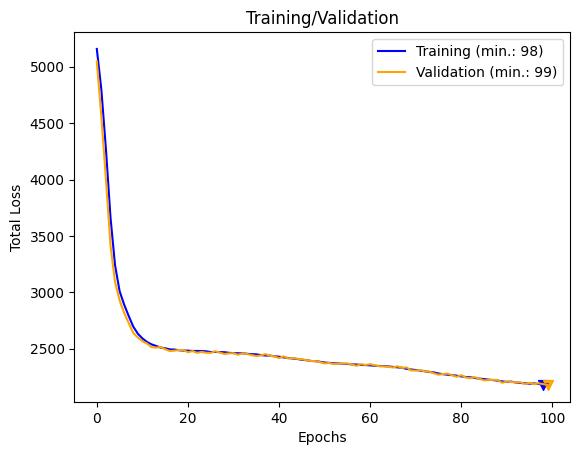

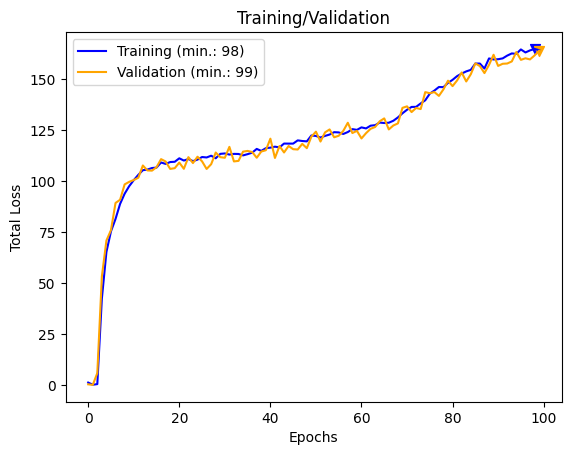

In [11]:
def train_valid_plot(losses, loss_type):

    if loss_type in ["total", "recon"]:
        min_train_loss_idx = np.argmin(losses['train'][loss_type])
        min_val_loss_idx = np.argmin(losses['valid'][loss_type])
    elif loss_type == "kl":
        min_train_loss_idx = np.argmax(losses['train'][loss_type])
        min_val_loss_idx = np.argmax(losses['valid'][loss_type])

    # Plot
    plt.plot(range(len(losses['train'][loss_type])), losses['train'][loss_type], label=f"Training (min.: {min_train_loss_idx})", color='blue')
    plt.plot(range(len(losses['valid'][loss_type])), losses['valid'][loss_type], label=f"Validation (min.: {min_val_loss_idx})", color='orange')

    # Adding triangle markers at the minimum points
    plt.scatter(min_train_loss_idx, losses['train'][loss_type][min_train_loss_idx], color='blue', marker='v', s=50)
    plt.scatter(min_val_loss_idx, losses['valid'][loss_type][min_val_loss_idx], color='orange', marker='v', s=50)

    # Setting the rest of the plot elements
    plt.legend()
    plt.ylabel('Total Loss')
    plt.xlabel('Epochs')
    plt.title('Training/Validation')
    plt.show()

train_valid_plot(losses, loss_type="recon")
train_valid_plot(losses, loss_type="kl")

In [12]:
# Test Model
test_loss, latent_data, test_xhat = evaluate_model(model,
                                                   test_dataloader,
                                                   loss_function,
                                                   hparams['beta'],
                                                   device)

print(f"Total test Loss: {test_loss['total']:.3f} ; "
      f"{hparams['loss_function']['reconstruction']}: {test_loss['recon']:.3f} ; "
      f"kl: {test_loss['kl']:.3f} ")

test_z = latent_data["z"]
z_mu = latent_data["mu"]
z_log_var = latent_data["log_var"]


Total test Loss: 2503.368 ; mse: 2175.079 ; kl: 164.145 


**Trajectory Reconstruction**

In [13]:
# RMSD

test_xhat = data_denormalization(test_xhat, max_value, min_value)
test_xhat = np.reshape(test_xhat, (n_frames, n_atoms, n_xyz))
traj_out = md.Trajectory(test_xhat, traj.topology)

rmsd_in = md.rmsd(traj, traj, 0)
rmsd_out = md.rmsd(traj, traj_out, 0)


#### **Latent Space Representation**

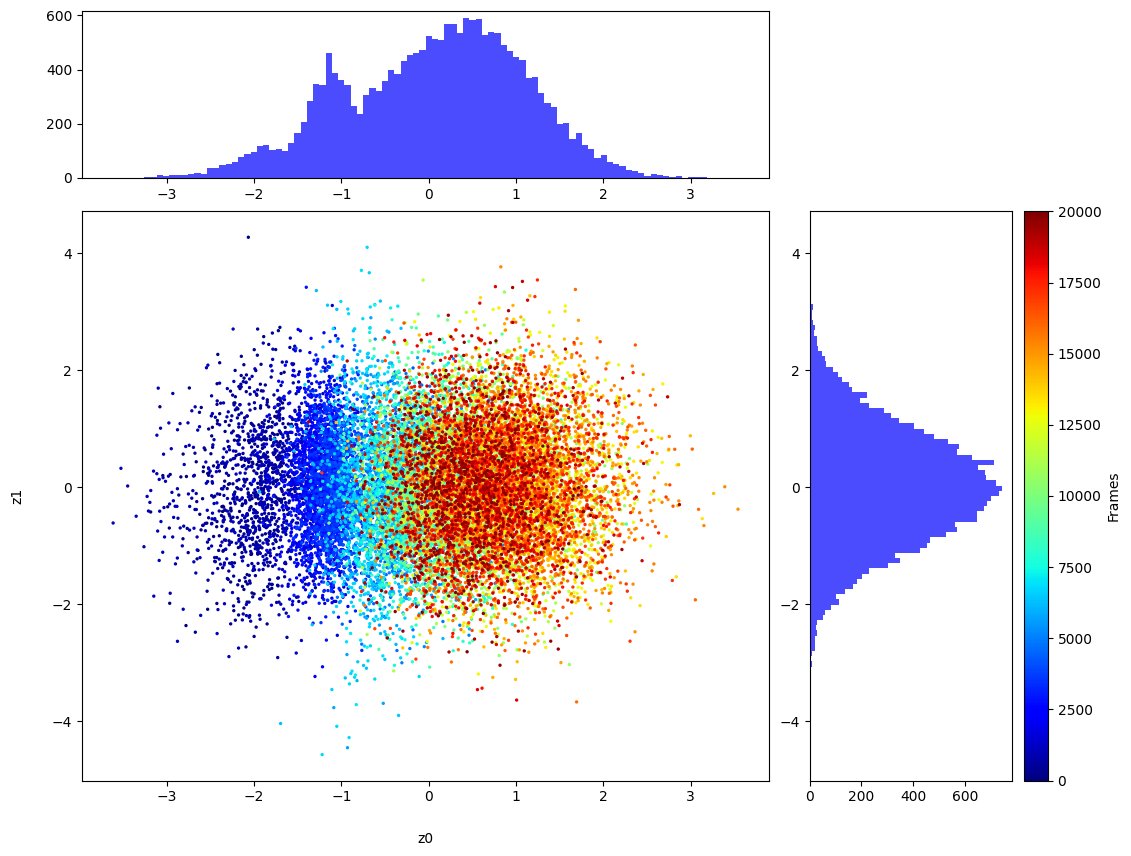

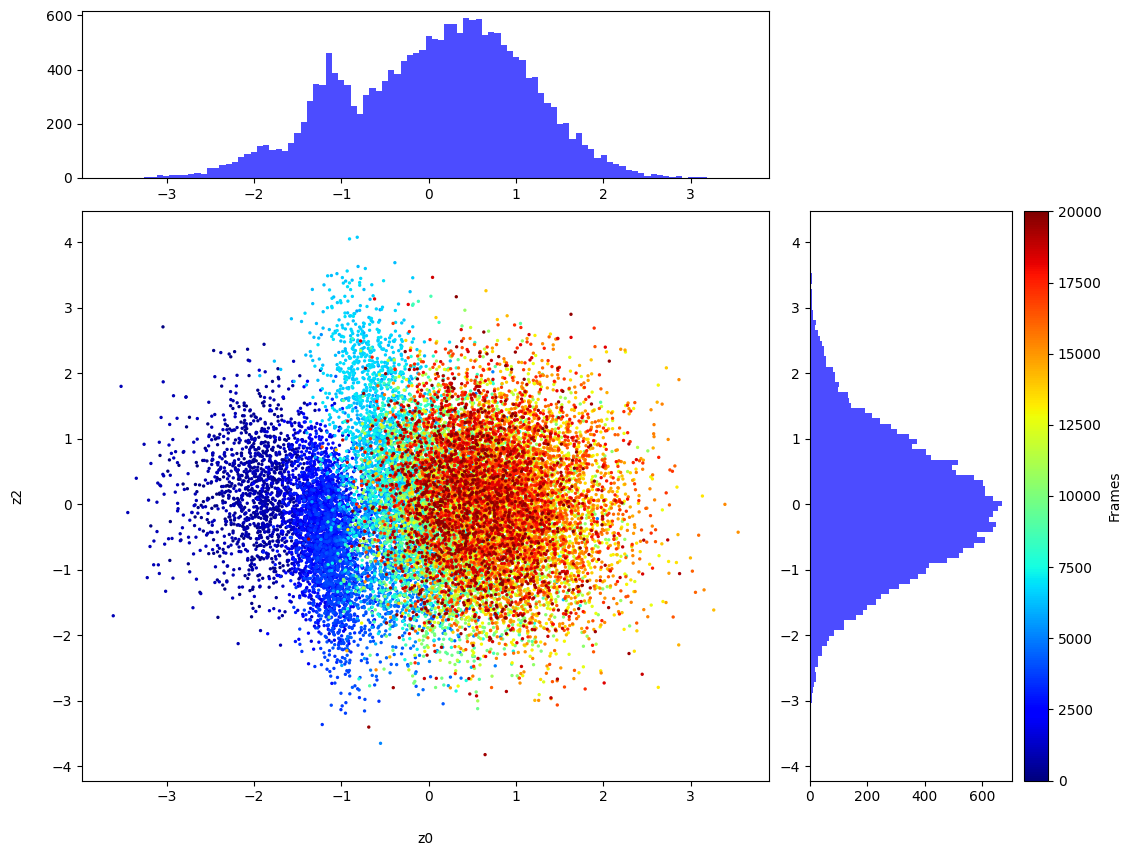

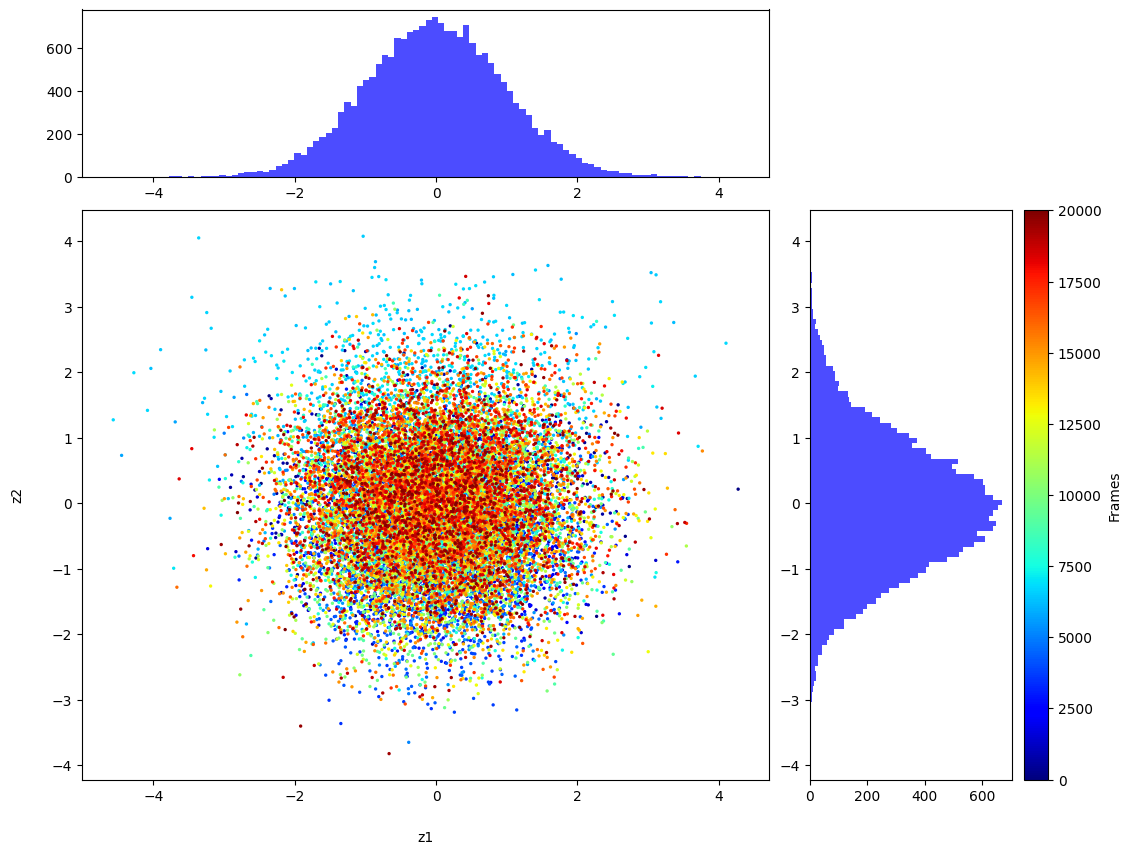

In [14]:
# Latent Space Representation
import matplotlib.gridspec as gridspec

def plot_latent_space(z, dims=[0,1]):
    gs = gridspec.GridSpec(4, 4)
    fig = plt.figure(figsize=(12, 10))

    ax_main = plt.subplot(gs[1:4, :3])
    ax_xDist = plt.subplot(gs[0, :3], sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:4, 3], sharey=ax_main)

    sc = ax_main.scatter(z[::1, dims[0]], z[::1, dims[1]], c=np.arange(len(z)), alpha=1, cmap='jet', s=2)

    # Position and size of colorbar based on ax_yDist
    pos = ax_yDist.get_position()
    cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])
    cbar = plt.colorbar(sc, cax=cbar_ax)
    cbar.set_label('Frames')

    # X-axis marginal distribution
    ax_xDist.hist(z[::1, dims[0]], bins=100, color='blue', alpha=0.7)

    # Y-axis marginal distribution
    ax_yDist.hist(z[::1, dims[1]], bins=100, color='blue', alpha=0.7, orientation='horizontal')

    ax_main.set_xlabel(f'z{dims[0]}', labelpad=20)
    ax_main.set_ylabel(f'z{dims[1]}', labelpad=20)

    plt.show()

for i in range(hparams['latent_dim']):
    for j in range(i+1, hparams['latent_dim']):
        plot_latent_space(test_z, dims=[i,j])


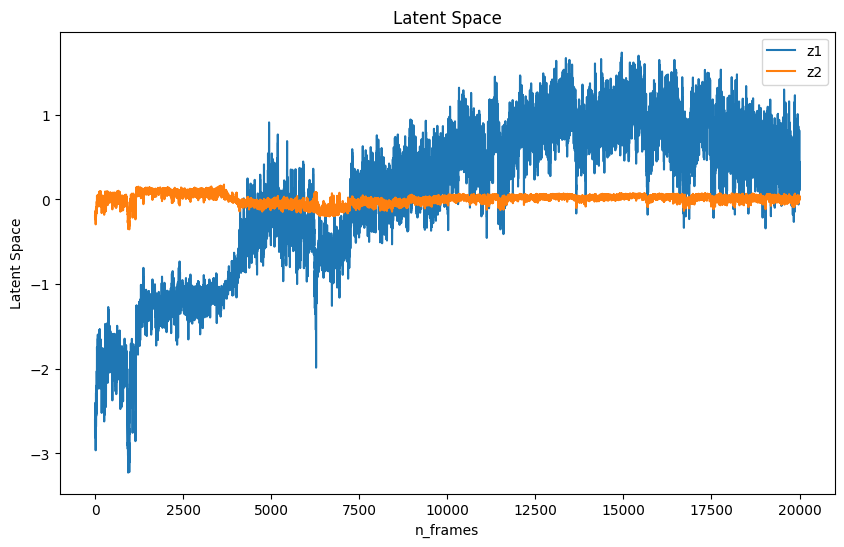

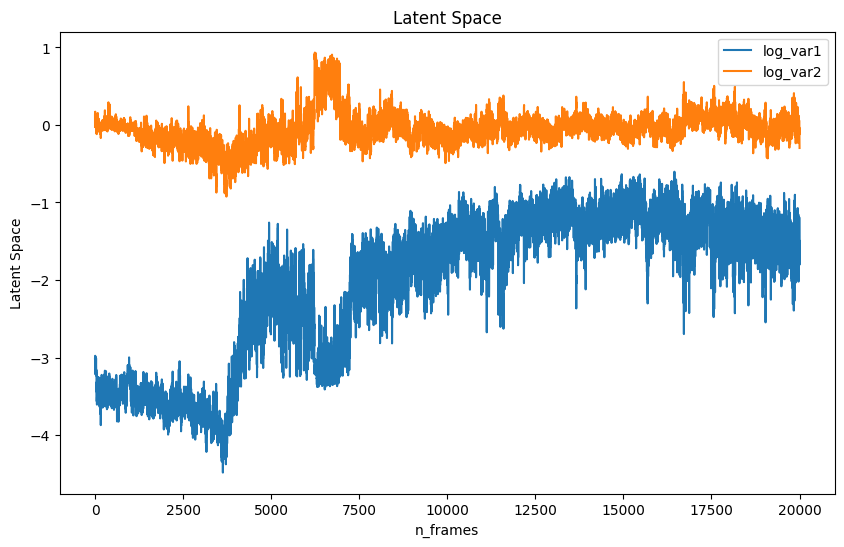

In [15]:
plot_dims = [0,1]

plt.figure(figsize=(10, 6))
plt.plot(range(n_frames), z_mu[:,plot_dims[0]], label=f"z{plot_dims[0]+1}")
plt.plot(range(n_frames), z_mu[:,plot_dims[1]], label=f"z{plot_dims[1]+1}")
plt.xlabel('n_frames')
plt.ylabel('Latent Space')
plt.legend()
plt.title('Latent Space')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(n_frames), z_log_var[:,plot_dims[0]], label=f"log_var{plot_dims[0]+1}")
plt.plot(range(n_frames), z_log_var[:,plot_dims[1]], label=f"log_var{plot_dims[1]+1}")
plt.xlabel('n_frames')
plt.ylabel('Latent Space')
plt.legend()
plt.title('Latent Space')
plt.show()

Multimodal latent dimension detected: z1 (Modes: 5)


<ipython-input-57-f0ebf9b755ae>:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


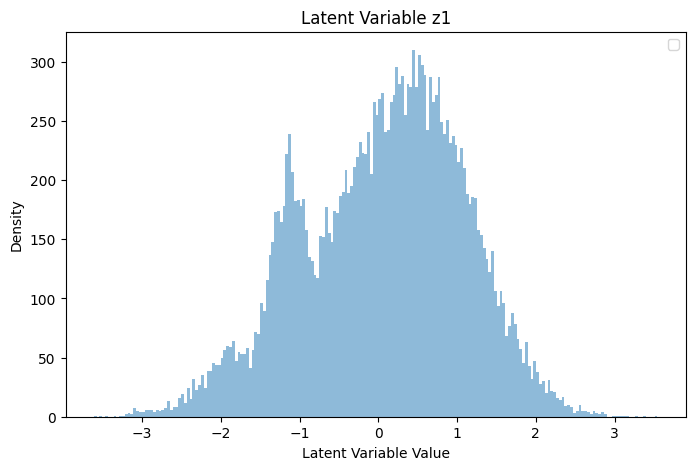

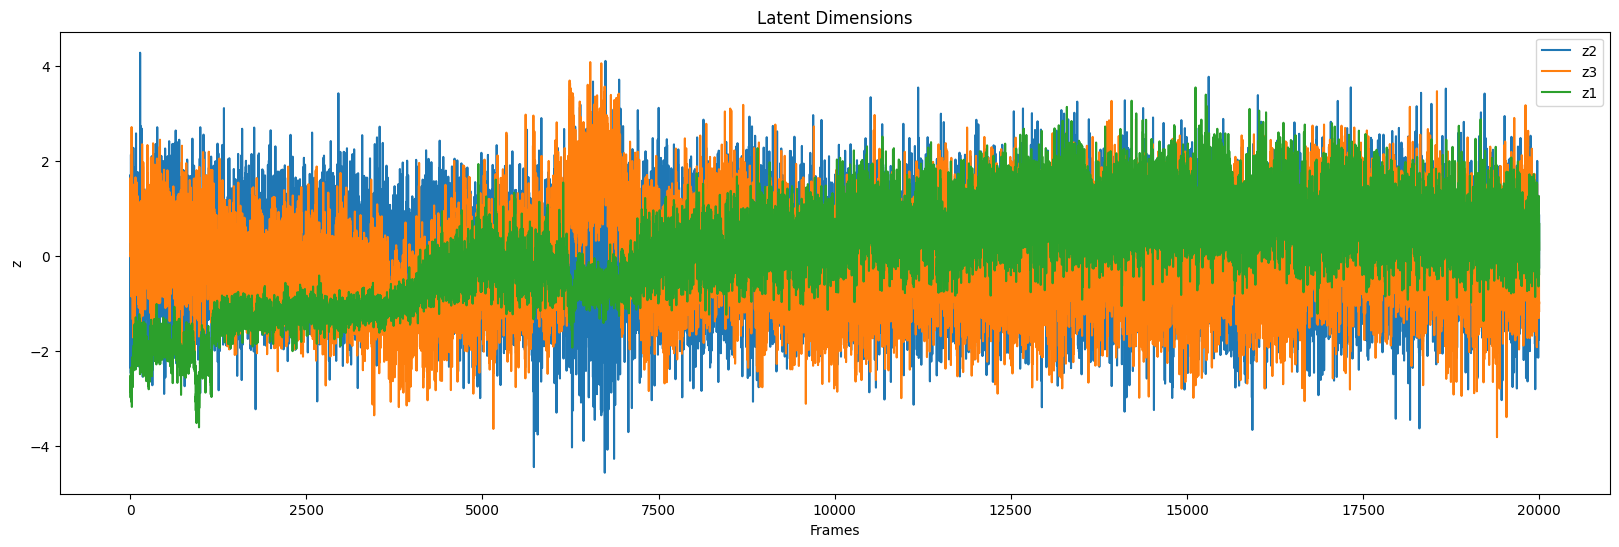

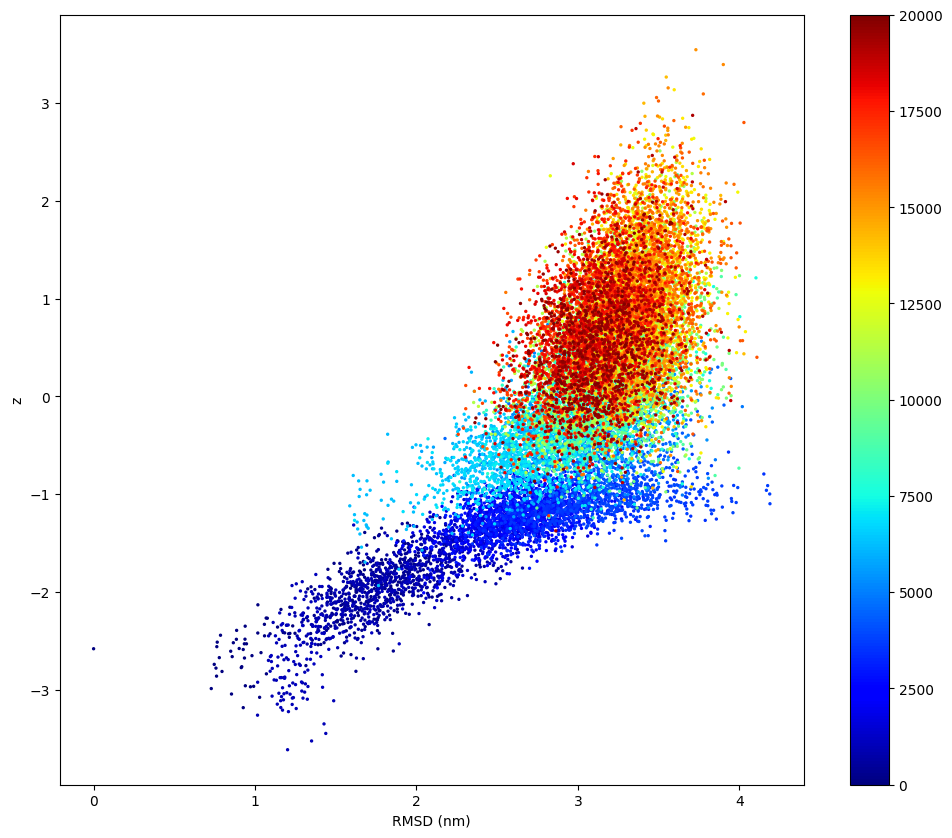

In [57]:
def is_multimodal_gmm(data, max_components=5, bic_threshold=10):
    bics = []
    for n in range(1, max_components + 1):
        gmm = GaussianMixture(n_components=n, covariance_type='full')
        gmm.fit(data.reshape(-1, 1))
        bics.append(gmm.bic(data.reshape(-1, 1)))

    n_modes = np.argmin(bics) + 1  # Optimal number of components
    return n_modes > 1, n_modes

for i in range(hparams["latent_dim"]):
    multimodal, n_modes = is_multimodal_gmm(test_z[:, i])
    if multimodal:
        multimodal_latent = i
        print(f"Multimodal latent dimension detected: z{i+1} (Modes: {n_modes})")
        break

plt.figure(figsize=(8, 5))
plt.hist(test_z[:, multimodal_latent], bins=200, alpha=0.5)
plt.xlabel("Latent Variable Value")
plt.ylabel("Density")
plt.title(f"Latent Variable z{multimodal_latent+1}")
plt.legend()
plt.show()

plt.figure(figsize=(20, 6))
for i in range(hparams["latent_dim"]):
    if i != multimodal_latent:
        plt.plot(test_z[:, i], label=f'z{i+1}')
plt.plot(test_z[:, multimodal_latent], label=f'z{multimodal_latent+1}')
plt.title("Latent Dimensions")
plt.ylabel("z")
plt.xlabel("Frames")
plt.legend()
plt.show()

plt.figure(figsize=(12, 10))
plt.scatter(rmsd_in, test_z[:,multimodal_latent], c=np.arange(len(test_z)), alpha=1, cmap='jet', s=2)
plt.xlabel('RMSD (nm)')
plt.ylabel('z')
plt.colorbar()
plt.show()

In [17]:
# Get Conformational Transition Trajectory

dt = 200

for i in range(hparams["latent_dim"]):
    z_variables = np.zeros_like(test_z)
    z_variables[:,i] = np.linspace(test_z[:,i].min()-0.5, test_z[:,i].max()+0.5, len(test_z))

    z_i = torch.FloatTensor(z_variables).to(device)
    xhat = model.decoder(z_i)

    xhat = xhat.detach().cpu().numpy()
    xhat = data_denormalization(xhat, max_value, min_value)
    xhat = np.reshape(xhat, (len(xhat), -1, 3))

    traj_z = md.Trajectory(xhat, traj.topology)
    traj_z.save_xtc(os.path.join(save_folder, f"WT_apo_vae_z{i+1}.xtc"))

    if i == multimodal_latent:
        transition_traj = md.Trajectory(xhat, traj.topology)
        transition_traj.save_xtc(os.path.join(save_folder, f"WT_apo_vae_transition.xtc"))
        transition_traj[0].save_pdb(os.path.join(save_folder, f"WT_apo_vae_transition_first.pdb"))
        transition_traj[-1].save_pdb(os.path.join(save_folder, f"WT_apo_vae_transition_last.pdb"))


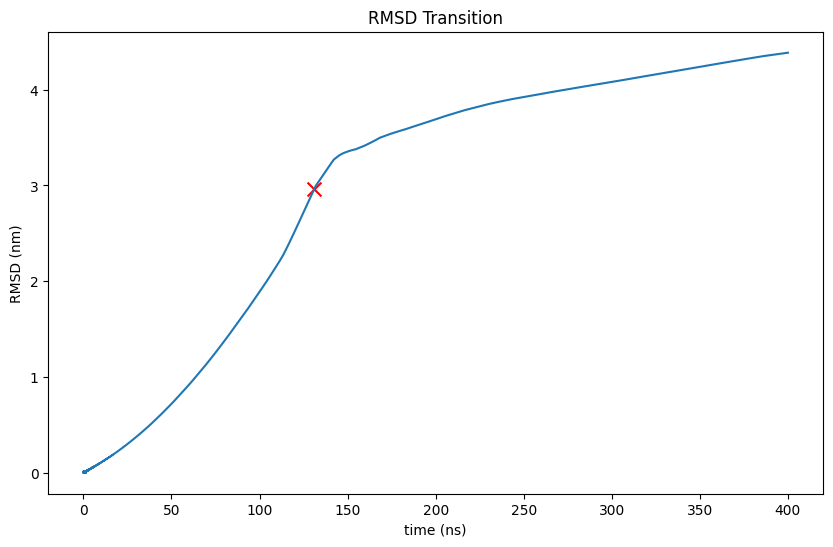

In [56]:
from scipy.signal import find_peaks

rmsd_transition = md.rmsd(transition_traj, transition_traj, 0)
slope = np.gradient(rmsd_transition**2)

elbow_candidates, _ = find_peaks(slope, prominence=0.1)
elbow_idx = np.argmax(np.abs(slope))
elbow_time = np.arange(len(rmsd_transition))[elbow_idx]*0.02
elbow_rmsd = rmsd_transition[elbow_idx]

# RMSD Transition Trajectory
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(rmsd_transition))*0.02, rmsd_transition)
plt.scatter(elbow_time, elbow_rmsd, color='red', marker='x', s=100)
plt.xlabel('time (ns)')
plt.ylabel('RMSD (nm)')
plt.title('RMSD Transition')
plt.show()


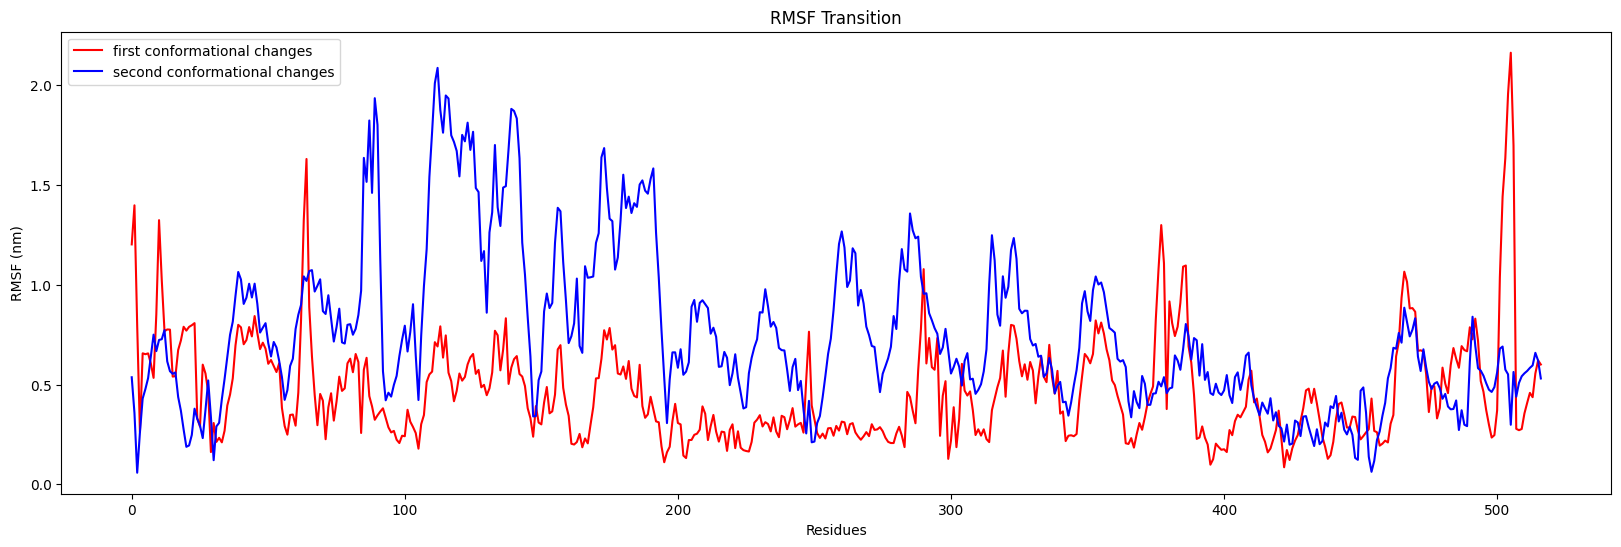

In [41]:
# RMSF of States (by RMSD)

rmsf_state1 = md.rmsf(transition_traj[elbow_idx:], transition_traj[elbow_idx:], 0)
rmsf_state2 = md.rmsf(transition_traj[:elbow_idx], transition_traj[:elbow_idx], 0)

plt.figure(figsize=(20, 6))
plt.plot(np.arange(len(rmsf_state2)), rmsf_state1, label="first conformational changes", color='r')
plt.plot(np.arange(len(rmsf_state1)), rmsf_state2, label="second conformational changes" , color='b')
plt.xlabel('Residues')
plt.ylabel('RMSF (nm)')
plt.title('RMSF Transition')
plt.legend()
plt.show()



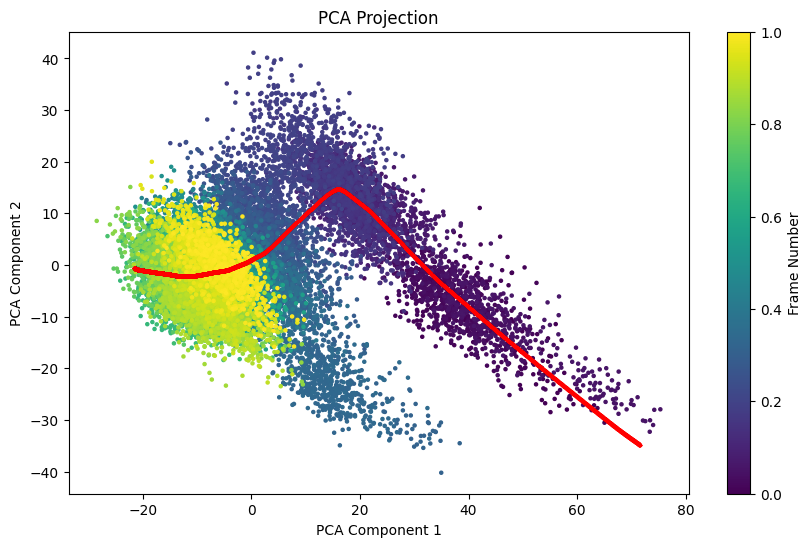

In [27]:
# Get transition trajectory

plot_dims = [0,1]

transition_data = transition_traj.xyz
transition_data = np.reshape(transition_data, (len(transition_data), -1))

# Perform PCA
pca = PCA(n_components=n_features)
pca_fit = pca.fit(data)

# Project decoded latent variable
pca_fit_transform = pca_fit.transform(data)
pca_transformed_data = pca_fit.transform(transition_data)

plt.figure(figsize=(10, 6))
plt.scatter(pca_fit_transform[:, plot_dims[0]], pca_fit_transform[:, plot_dims[1]], s=5, c=np.arange(pca_fit_transform.shape[0]), cmap='viridis')
plt.scatter(pca_transformed_data[:, plot_dims[0]], pca_transformed_data[:, plot_dims[1]], color='red', s=2)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection')
plt.colorbar(label='Frame Number')
plt.show()

# 2. Perform tICA (maybe if we train with timelag we can get the right RC)

# tica = TICA(dim=n_features, lagtime=1)
# tica.fit(data)
# tica_fit_transform = tica.transform(data)
# tica_transformed_data = tica.transform(transition_data)

# plt.figure(figsize=(10, 6))
# plt.scatter(tica_fit_transform[:, plot_dims[0]], tica_fit_transform[:, plot_dims[1]], s=5, c=np.arange(tica_fit_transform.shape[0]), cmap='viridis')
# plt.scatter(tica_transformed_data[:, plot_dims[0]], tica_transformed_data[:, plot_dims[1]], color='red', s=2)
# plt.xlabel('TICA Component 1')
# plt.ylabel('TICA Component 2')
# plt.title('TICA Projection')
# plt.colorbar(label='Frame Number')
# plt.show()

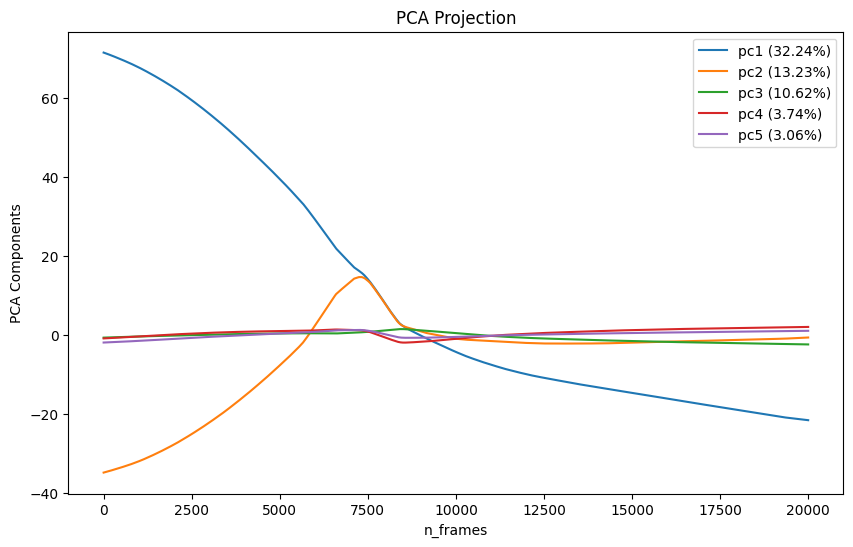

In [28]:

plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(range(n_frames),
             pca_transformed_data[:, i],
             label=f"pc{i+1} ({100*pca.explained_variance_ratio_[i]:.2f}%)")
plt.xlabel('n_frames')
plt.ylabel('PCA Components')
plt.legend()
plt.title('PCA Projection')
plt.show()

# plt.figure(figsize=(10, 6))
# for i in range(5):
#       plt.plot(range(n_frames), tica_transformed_data[:, i], label=f"tica{i+1}")
# plt.xlabel('n_frames')
# plt.ylabel('TICA Component 2')
# plt.legend()
# plt.title('TICA Projection')
# plt.show()

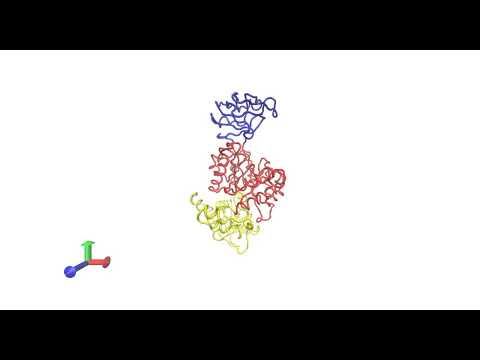

In [29]:
# Decoded Reaction Coordinate of most important Latent Variable

from IPython.display import YouTubeVideo
YouTubeVideo("bm_qUuEbg4k", width=800, height=600)

In [ ]:
# from google.colab import output
# output.enable_custom_widget_manager()
# !pip install simpletraj
# !pip install nglview==3.0.8
# !pip install ipywidgets==7.7.2
# import nglview as nv
# import ipywidgets


In [ ]:
# # Create an NGLView widget
# view = nv.show_simpletraj(nv.SimpletrajTrajectory("WT_apo_vae_z3.xtc", "WT_apo_vae_z3.pdb"), gui=True)
# view.add_representation(repr_type='tube', colorScheme = 'atomindex')
# view._remote_call('setSize', target='Widget', args=['800px','600px'])
# view
